# Creation of the target variable: Actual Time of Arrival

Table of contents <a id='top'>

1. [Getting the data](#get)
2. [Explorations and Visualizations](#explore)
3. [Getting the Distances to the bus stops](#distances)
4. [Times of Arrival](#ta)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
from jupyterthemes import jtplot
import datetime as dt
import seaborn as sns
import json

import matplotlib.pyplot as plt
%matplotlib inline
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

ROOT_DIR = '/home/miguel/github_repos/python-ds'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')

DATA = os.path.join(DATA_INTERIM, 'data.pkl')
PATHS = os.path.join(DATA_PROCESSED, 'paths.pkl')
SIM_DATA = os.path.join(DATA_INTERIM, 'sim_data.pkl')

SRC_DIR = os.path.join(ROOT_DIR, 'src')

import sys
sys.path.append(SRC_DIR)

import data.create_from_sim as cfs
import data.create_from_txt as cft
import data.paths as p

## 1. Getting the data <a id='get'>
[Top](#top)

In [2]:
print('Creating simulated data')
# _ = cfs.parse_data(save=True)  # Comment if already run, to save time
print('Creating text data')
# _ = cft.parse_data(save=True)  # Comment if already run, to save time
print('Creating paths')
# _ = p.get_paths(save=True)  # Comment if already run, to save time

data = pd.read_pickle(DATA)
paths = pd.read_pickle(PATHS)
sim_data = pd.read_pickle(SIM_DATA)

Creating simulated data
Creating text data
Creating paths


Let's check that we can retreive the paths for the lines

In [3]:
data.head()

codigoBus        lat linea       long           timestamp       uid  \
0        241 -34.927967  7517 -56.161850 2018-10-02 14:04:37  7517_241   
1        710 -34.870167  7921 -56.111443 2018-10-02 14:04:37  7921_710   
2        961 -34.851887   343 -56.129030 2018-10-02 14:04:37   343_961   
3         78 -34.869860  2454 -56.022057 2018-10-02 14:04:37   2454_78   
4         15 -34.882000   217 -56.183617 2018-10-02 14:04:37    217_15   

              x            y  
0   2752.398939 -2745.069154  
1   8025.685647  3681.997606  
2   6185.836155  5714.640865  
3  17376.728274  3716.134448  
4    475.262196  2366.228039

In [4]:
paths.head()

calle  codigoParada           esquina        lat  \
0  AV DRA MA L SALDUN DE RODRIGUEZ          4836        AV BOLIVIA -34.881817   
1                       AV BOLIVIA          2953       JOSE ORDEIG -34.879045   
2                       AV BOLIVIA          2954            VERONA -34.877140   
3                       AV BOLIVIA          2955  DR ELIAS REGULES -34.875377   
4                       AV BOLIVIA          2956          CALLE N1 -34.873713   

  linea       long  ordinal             x            y  
0   217 -56.083301        1  10969.744826  2386.594612  
1   217 -56.085743        2  10714.269869  2694.818891  
2   217 -56.088758        3  10398.836431  2906.584242  
3   217 -56.091500        4  10112.028195  3102.689054  
4   217 -56.094133        5   9836.567948  3287.715835

In [5]:
sim_data.head()

codigoBus   id        lat linea       long           timestamp       uid  \
0        241  241 -34.927967  7517 -56.161850 2018-10-02 14:04:52  7517_241   
1        710  710 -34.870167  7921 -56.111473 2018-10-02 14:04:52  7921_710   
2        961  961 -34.852690   343 -56.129692 2018-10-02 14:04:52   343_961   
3         78   78 -34.871360  2454 -56.022778 2018-10-02 14:04:52   2454_78   
4         15   15 -34.881184   217 -56.185750 2018-10-02 14:04:52    217_15   

              x            y  
0   2752.398939 -2745.069154  
1   8022.547222  3681.997606  
2   6116.581571  5625.351339  
3  17301.301454  3549.342058  
4    252.120161  2456.963099

In [6]:
lines = data.linea.unique()
lines.shape

(139,)

In [7]:
paths.linea.unique().shape

(103,)

Bad thing. Not all the lines are in the paths. Perhaps the only ones present are for the real simulated data. Let's try to see that.

In [8]:
sim_data.linea.unique().shape

(75,)

In [9]:
import utils

In [10]:
utils.common_values(sim_data.linea.unique(), paths.linea.unique())

Intersection: 41
Total set 1: 75
Not in set 2: 34
Total set 2: 103
Not in set 1: 62
Total: 137


In [11]:
utils.common_values(data.linea.unique(), paths.linea.unique())

Intersection: 46
Total set 1: 139
Not in set 2: 93
Total set 2: 103
Not in set 1: 57
Total: 196


That is not good. The paths info is not reliable. Maybe the bus stops coordinates are OK though.

In [12]:
paths.codigoParada.unique().shape

(1130,)

In [13]:
stops = paths.groupby('codigoParada').mean().drop('ordinal', axis=1)
print(stops.shape)
stops.head()

(1130, 4)


lat       long            x            y
codigoParada                                                
553          -34.892023 -56.154605  3510.304538  1251.694658
554          -34.893632 -56.151545  3830.469065  1072.860194
574          -34.907394 -56.198255 -1056.080579  -457.496250
575          -34.907180 -56.194979  -713.333119  -433.708180
577          -34.906917 -56.191511  -350.608147  -404.414225

In [14]:
path = p.get_line_path(paths, '217')
path.head()

calle  codigoParada           esquina        lat  \
0  AV DRA MA L SALDUN DE RODRIGUEZ          4836        AV BOLIVIA -34.881817   
1                       AV BOLIVIA          2953       JOSE ORDEIG -34.879045   
2                       AV BOLIVIA          2954            VERONA -34.877140   
3                       AV BOLIVIA          2955  DR ELIAS REGULES -34.875377   
4                       AV BOLIVIA          2956          CALLE N1 -34.873713   

  linea       long  ordinal             x            y  
0   217 -56.083301        1  10969.744826  2386.594612  
1   217 -56.085743        2  10714.269869  2694.818891  
2   217 -56.088758        3  10398.836431  2906.584242  
3   217 -56.091500        4  10112.028195  3102.689054  
4   217 -56.094133        5   9836.567948  3287.715835

In [15]:
data.head()

codigoBus        lat linea       long           timestamp       uid  \
0        241 -34.927967  7517 -56.161850 2018-10-02 14:04:37  7517_241   
1        710 -34.870167  7921 -56.111443 2018-10-02 14:04:37  7921_710   
2        961 -34.851887   343 -56.129030 2018-10-02 14:04:37   343_961   
3         78 -34.869860  2454 -56.022057 2018-10-02 14:04:37   2454_78   
4         15 -34.882000   217 -56.183617 2018-10-02 14:04:37    217_15   

              x            y  
0   2752.398939 -2745.069154  
1   8025.685647  3681.997606  
2   6185.836155  5714.640865  
3  17376.728274  3716.134448  
4    475.262196  2366.228039

In [3]:
def get_bus_path(data, uid):
    return data[data.uid == uid]

## 2. Explorations and Visualizations <a id='explore'>
[Top](#top)

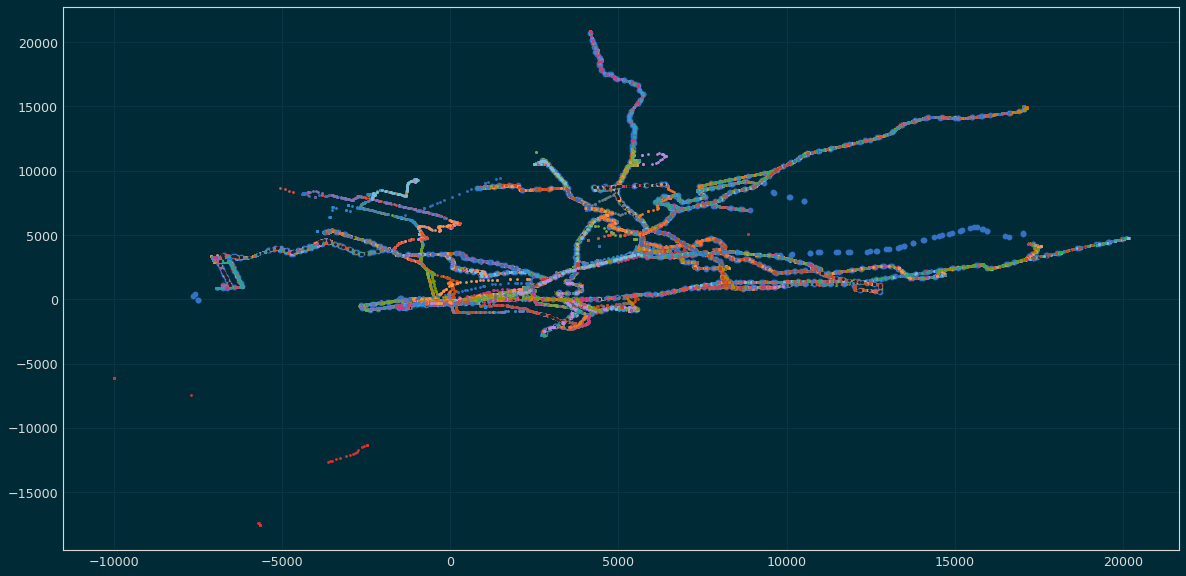

In [17]:
plt.scatter(stops.x, stops.y)
for uid in data.uid.unique():
    path = get_bus_path(data, uid)
    plt.plot(path.x, path.y, '.')

In [18]:
utils.common_values(data.linea.unique(), paths.linea.unique())

Intersection: 46
Total set 1: 139
Not in set 2: 93
Total set 2: 103
Not in set 1: 57
Total: 196


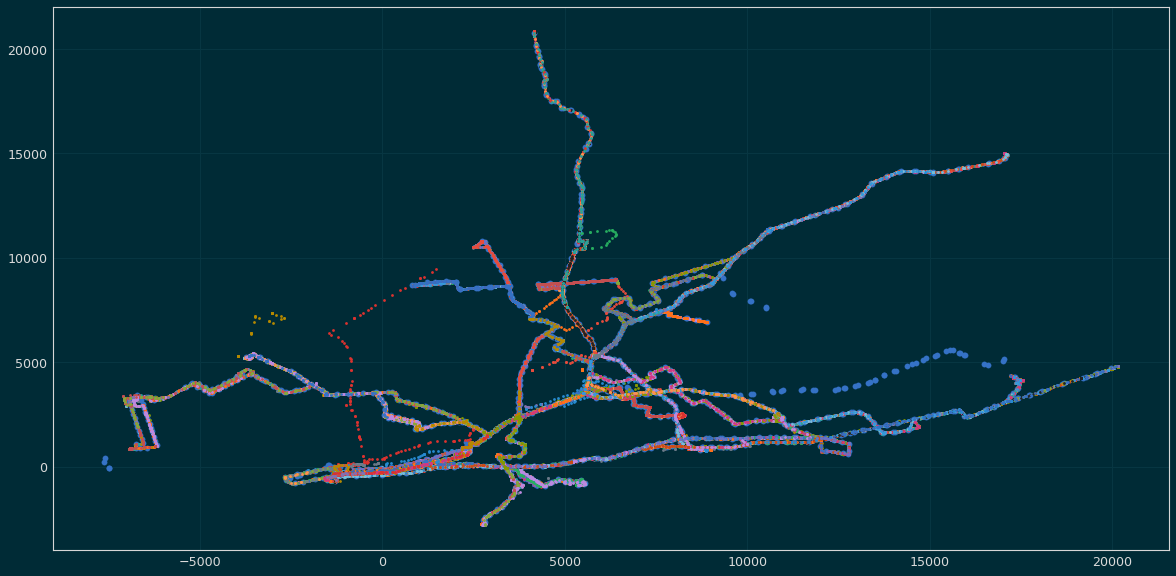

In [19]:
plt.scatter(stops.x, stops.y)
for uid in sim_data.uid.unique():
    path = get_bus_path(data, uid)
    plt.plot(path.x, path.y, '.')

So, there are some stops without paths, and some paths without stops. Let's keep the ones that are easy first.

In [20]:
known_lines = paths.linea.unique()
known_lines.shape

(103,)

In [4]:
def get_easy_data(data, paths):
    known_lines = paths.linea.unique()
    return data[data.linea.isin(known_lines)]

In [5]:
easy_data = get_easy_data(data, paths)

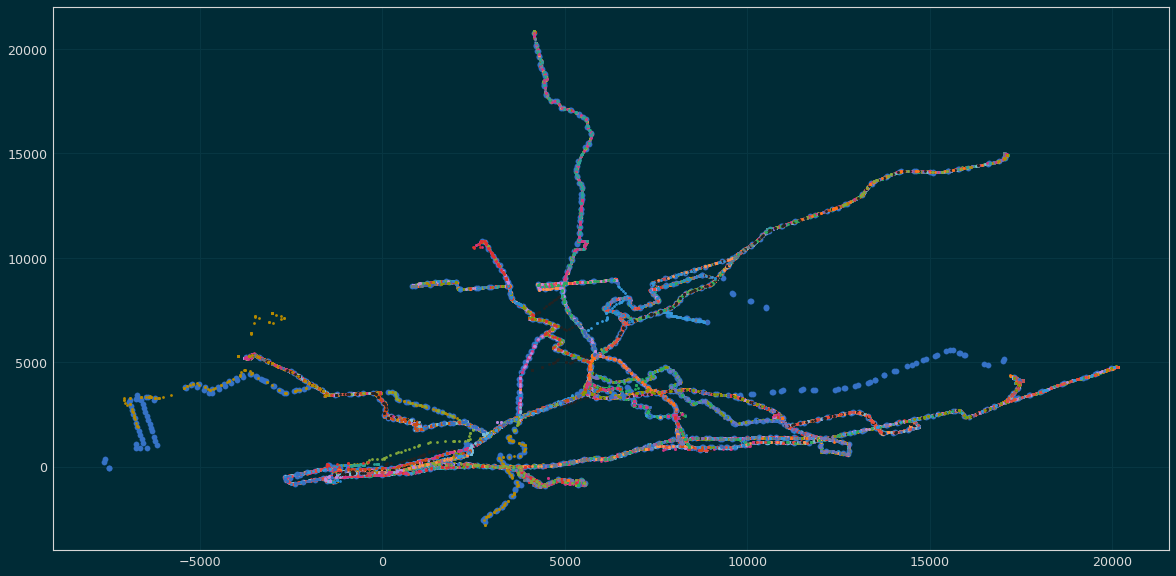

In [23]:
plt.scatter(stops.x, stops.y)
for uid in easy_data.uid.unique():
    path = get_bus_path(data, uid)
    plt.plot(path.x, path.y, '.')

In [24]:
easy_data.head()

codigoBus        lat linea       long           timestamp       uid  \
1        710 -34.870167  7921 -56.111443 2018-10-02 14:04:37  7921_710   
2        961 -34.851887   343 -56.129030 2018-10-02 14:04:37   343_961   
4         15 -34.882000   217 -56.183617 2018-10-02 14:04:37    217_15   
6         15 -34.905777   231 -56.189304 2018-10-02 14:04:37    231_15   
8         29 -34.889034   218 -56.160700 2018-10-02 14:04:37    218_29   

             x            y  
1  8025.685647  3681.997606  
2  6185.836155  5714.640865  
4   475.262196  2366.228039  
6  -119.678616  -277.653732  
8  2872.705240  1584.082925

In [25]:
line = '231'
line_uids = easy_data[easy_data.linea == line].uid.unique()
line_uids

array(['231_15', '231_77', '231_715', '231_670', '231_33', '231_63',
       '231_98', '231_961', '231_967', '231_915'], dtype=object)

In [26]:
line = line_uids[0].split('_')[0]

In [27]:
sub_paths = paths[paths.linea == line]

In [6]:
def show_path(data, paths, uids):
    line = uid.split('_')[0]
    sub_paths = paths[paths.linea == line]
    stops = sub_paths.groupby('codigoParada').mean().drop('ordinal', axis=1)
    plt.scatter(stops.x, stops.y)
    path = get_bus_path(data, uid)
    plt.plot(path.x, path.y, '.')

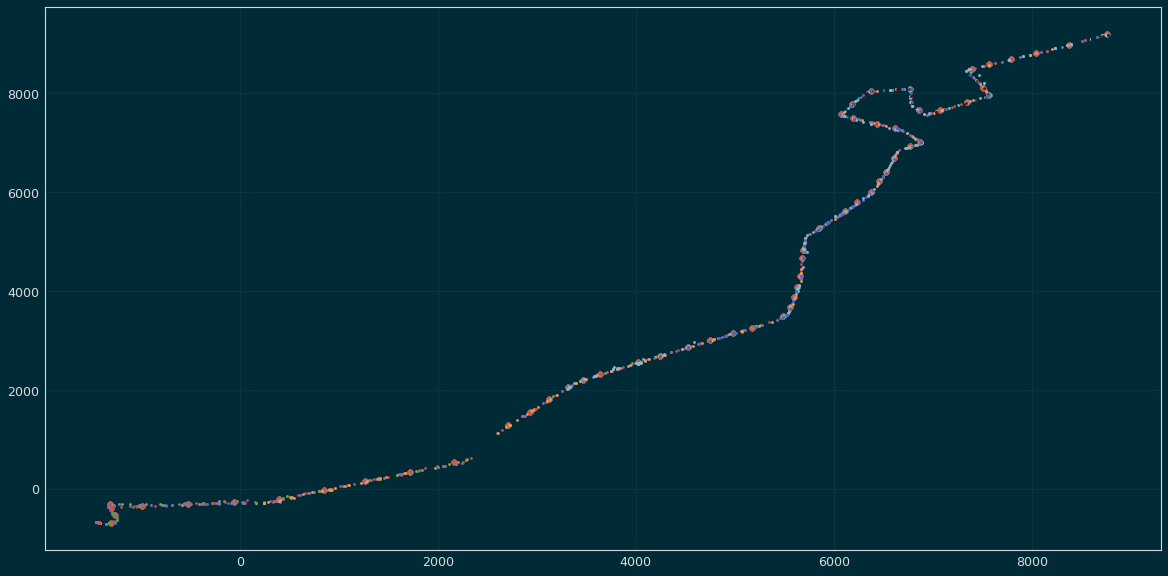

In [29]:
for uid in line_uids:
    show_path(data, paths, uid)

Let's make a function that gets the two nearest stops (for the corresponding line) for a given uid point in space

Let's focus on line 231

## 3. Getting the distances to all the bus stops <a id='distances'>
[Top](#top)

First, let's join a dataframe with all the relevant bus stops, to fill with the distances

In [30]:
easy_data = get_easy_data(data, paths)

In [31]:
line = '231'

In [7]:
def relevant_stops(paths, line):
    sub_paths = paths[paths.linea == line]
    stops = sub_paths.groupby('codigoParada').mean().drop('ordinal', axis=1)
    stops = stops.reset_index()
    return stops

In [8]:
def add_stop_cols(data, stops):
    cols = ['d_' + str(stop) for stop in stops.codigoParada]
    distances = pd.DataFrame(np.full((data.shape[0], len(cols)), np.nan),
                             columns=cols,
                             index=data.index)
    return data.join(distances)

In [9]:
def relevant_stops_to_data(data, paths):
    data_lines = data.linea.unique()
    sub_paths = paths[paths.linea.isin(data_lines)]
    stops = sub_paths.groupby('codigoParada').mean().drop('ordinal', axis=1)
    stops = stops.reset_index()
    return add_stop_cols(data, stops)

In [10]:
from numpy.linalg import norm
from tqdm import tqdm

def get_stop_distances(data, paths, line):
    print('Getting distances for line {}'.format(line))
    stops = relevant_stops(paths, line)
    line_data = data[data.linea == line]
    for stop_idx in tqdm(range(stops.shape[0])):
        stop = stops.iloc[stop_idx]
        line_data['d_' + str(int(stop.codigoParada))] = line_data[['x', 'y']].apply(
            lambda x: norm(x.values - stop[['x', 'y']]), axis=1)
    data.update(line_data)
    return data

In [11]:
def get_s_d_para(data):
    return get_stop_distances(data, paths=paths, line=data.linea.iloc[0])

In [37]:
r_stops = relevant_stops(paths, line)
print(r_stops.shape)
r_stops.head()

(57, 5)


codigoParada        lat       long            x            y
0          2014 -34.820600 -56.104419  8760.525448  9193.613690
1          2015 -34.824042 -56.111315  8039.105787  8810.829992
2          2016 -34.825158 -56.113730  7786.403983  8686.780266
3          2024 -34.826872 -56.117523  7389.664813  8496.199871
4          2025 -34.830887 -56.127254  6371.669406  8049.682351

In [38]:
easy_data = relevant_stops_to_data(easy_data, paths)
print(easy_data.shape)
easy_data.head()

(140060, 1052)


codigoBus        lat linea       long           timestamp       uid  \
1        710 -34.870167  7921 -56.111443 2018-10-02 14:04:37  7921_710   
2        961 -34.851887   343 -56.129030 2018-10-02 14:04:37   343_961   
4         15 -34.882000   217 -56.183617 2018-10-02 14:04:37    217_15   
6         15 -34.905777   231 -56.189304 2018-10-02 14:04:37    231_15   
8         29 -34.889034   218 -56.160700 2018-10-02 14:04:37    218_29   

             x            y  d_553  d_554   ...    d_6193  d_6194  d_6195  \
1  8025.685647  3681.997606    NaN    NaN   ...       NaN     NaN     NaN   
2  6185.836155  5714.640865    NaN    NaN   ...       NaN     NaN     NaN   
4   475.262196  2366.228039    NaN    NaN   ...       NaN     NaN     NaN   
6  -119.678616  -277.653732    NaN    NaN   ...       NaN     NaN     NaN   
8  2872.705240  1584.082925    NaN    NaN   ...       NaN     NaN     NaN   

   d_6196  d_6274  d_6276  d_6283  d_6284  d_6299  d_6301  
1     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
4     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
6     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
8     NaN     NaN     NaN     NaN     NaN     NaN     NaN  

[5 rows x 1052 columns]

In [39]:
# line_data = get_stop_distances(easy_data, paths, line)
# line_data.head()

In [40]:
# line_data.iloc[:,8:].isnull().mean().sort_values()

In [44]:
easy_data = get_easy_data(data, paths)
easy_data = relevant_stops_to_data(easy_data, paths)
new_data = utils.apply_parallel(easy_data.groupby('linea'), get_s_d_para)

('1476', '1483', '217', '218', '227', '231', '237', '2388', '2390', '2391', '2392', '2393', '242', '254', '266', '278', '340', '343', '372', '395', '455', '498', '522', '571', '593', '7512', '7513', '7526', '7529', '7703', '7704', '7705', '7898', '7899', '7902', '7903', '7918', '7919', '7920', '7921', '7926', '7927', '7928', '7929', '863', '873')
Getting distances for line 1476


  0%|          | 0/52 [00:00<?, ?it/s]

Getting distances for line 218


  0%|          | 0/63 [00:00<?, ?it/s]

Getting distances for line 237


  0%|          | 0/52 [00:00<?, ?it/s]

Getting distances for line 2391


100%|██████████| 52/52 [02:58<00:00,  3.37s/it]


Getting distances for line 1483


 25%|██▌       | 12/48 [00:42<02:05,  3.50s/it]

Getting distances for line 2392


100%|██████████| 52/52 [04:53<00:00,  5.67s/it]


Getting distances for line 2388


100%|██████████| 48/48 [02:56<00:00,  3.78s/it]


Getting distances for line 217


100%|██████████| 63/63 [05:36<00:00,  5.52s/it]


Getting distances for line 2393


100%|██████████| 51/51 [06:15<00:00,  7.09s/it]


Getting distances for line 2390


100%|██████████| 48/48 [03:23<00:00,  4.25s/it]


Getting distances for line 242


100%|██████████| 63/63 [14:30<00:00, 13.21s/it]


Getting distances for line 227


 84%|████████▍ | 47/56 [02:10<00:25,  2.78s/it]

Getting distances for line 278


 60%|█████▉    | 40/67 [04:03<02:51,  6.34s/it]

Getting distances for line 340


100%|██████████| 56/56 [02:35<00:00,  2.72s/it]


Getting distances for line 231


100%|██████████| 62/62 [12:27<00:00, 11.53s/it]


Getting distances for line 372


100%|██████████| 57/57 [01:36<00:00,  1.65s/it]


Getting distances for line 498


100%|██████████| 67/67 [06:47<00:00,  5.87s/it]


Getting distances for line 254


100%|██████████| 80/80 [03:18<00:00,  2.73s/it]


Getting distances for line 522


100%|██████████| 66/66 [06:16<00:00,  7.29s/it]


Getting distances for line 395


100%|██████████| 73/73 [08:05<00:00,  8.52s/it]


Getting distances for line 343


100%|██████████| 82/82 [03:39<00:00,  3.68s/it]


Getting distances for line 571


100%|██████████| 50/50 [00:00<00:00, 63.75it/s]


Getting distances for line 593


100%|██████████| 66/66 [00:04<00:00, 17.12it/s]


Getting distances for line 7512


100%|██████████| 85/85 [00:41<00:00,  2.23it/s]


Getting distances for line 7513


 75%|███████▍  | 41/55 [07:14<02:38, 11.33s/it]

Getting distances for line 7526


 80%|████████  | 44/55 [07:43<01:52, 10.22s/it]

Getting distances for line 7529


100%|██████████| 55/55 [00:19<00:00,  3.06it/s]


Getting distances for line 7703


100%|██████████| 55/55 [09:29<00:00,  9.57s/it]


Getting distances for line 266


100%|██████████| 22/22 [01:35<00:00,  4.37s/it]


Getting distances for line 7704


100%|██████████| 22/22 [01:33<00:00,  4.26s/it]


Getting distances for line 7705


100%|██████████| 48/48 [00:01<00:00, 32.77it/s]


Getting distances for line 7898


100%|██████████| 66/66 [07:44<00:00,  6.55s/it]


Getting distances for line 455


100%|██████████| 52/52 [00:00<00:00, 180.64it/s]


Getting distances for line 7899


100%|██████████| 73/73 [07:58<00:00,  6.24s/it]


Getting distances for line 7918


100%|██████████| 54/54 [03:55<00:00,  4.47s/it]


Getting distances for line 7921


 66%|██████▌   | 44/67 [03:10<01:39,  4.33s/it]

Getting distances for line 7919


 46%|████▌     | 21/46 [01:36<01:57,  4.70s/it]

Getting distances for line 7902


100%|██████████| 48/48 [03:06<00:00,  3.75s/it]


Getting distances for line 7926


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Getting distances for line 7927


100%|██████████| 16/16 [00:13<00:00,  1.27it/s]


Getting distances for line 7928


100%|██████████| 58/58 [09:17<00:00,  9.48s/it]


Getting distances for line 873


100%|██████████| 22/22 [00:48<00:00,  2.04s/it]


Getting distances for line 7929


100%|██████████| 46/46 [03:36<00:00,  4.73s/it]


Getting distances for line 7920


100%|██████████| 22/22 [00:43<00:00,  2.06s/it]


Getting distances for line 863


100%|██████████| 39/39 [03:07<00:00,  4.70s/it]


Getting distances for line 7903


100%|██████████| 66/66 [03:51<00:00,  2.40s/it]


In [50]:
new_data = new_data.reset_index('group_index', drop=True)
new_data.head()

codigoBus        lat linea       long           timestamp       uid  \
24         275 -34.883250  1476 -56.083275 2018-10-02 14:04:37  1476_275   
25         263 -34.903110  1476 -56.165750 2018-10-02 14:04:37  1476_263   
49         525 -34.904220  1476 -56.182335 2018-10-02 14:04:37  1476_525   
157        278 -34.894333  1476 -56.109890 2018-10-02 14:04:37  1476_278   
212        275 -34.883167  1476 -56.083305 2018-10-02 14:04:52  1476_275   

                x            y  d_553  d_554   ...    d_6193  d_6194  d_6195  \
24   10972.457722  2227.234381    NaN    NaN   ...       NaN     NaN     NaN   
25    2344.403657    18.903138    NaN    NaN   ...       NaN     NaN     NaN   
49     609.377568  -104.523231    NaN    NaN   ...       NaN     NaN     NaN   
157   8188.151460   994.861009    NaN    NaN   ...       NaN     NaN     NaN   
212  10969.319297  2236.463560    NaN    NaN   ...       NaN     NaN     NaN   

     d_6196        d_6274  d_6276  d_6283  d_6284  d_6299  d_6301  
24      NaN  12585.578919     NaN     NaN     NaN     NaN     NaN  
25      NaN   3709.119908     NaN     NaN     NaN     NaN     NaN  
49      NaN   1971.069917     NaN     NaN     NaN     NaN     NaN  
157     NaN   9628.891538     NaN     NaN     NaN     NaN     NaN  
212     NaN  12584.401298     NaN     NaN     NaN     NaN     NaN  

[5 rows x 1052 columns]

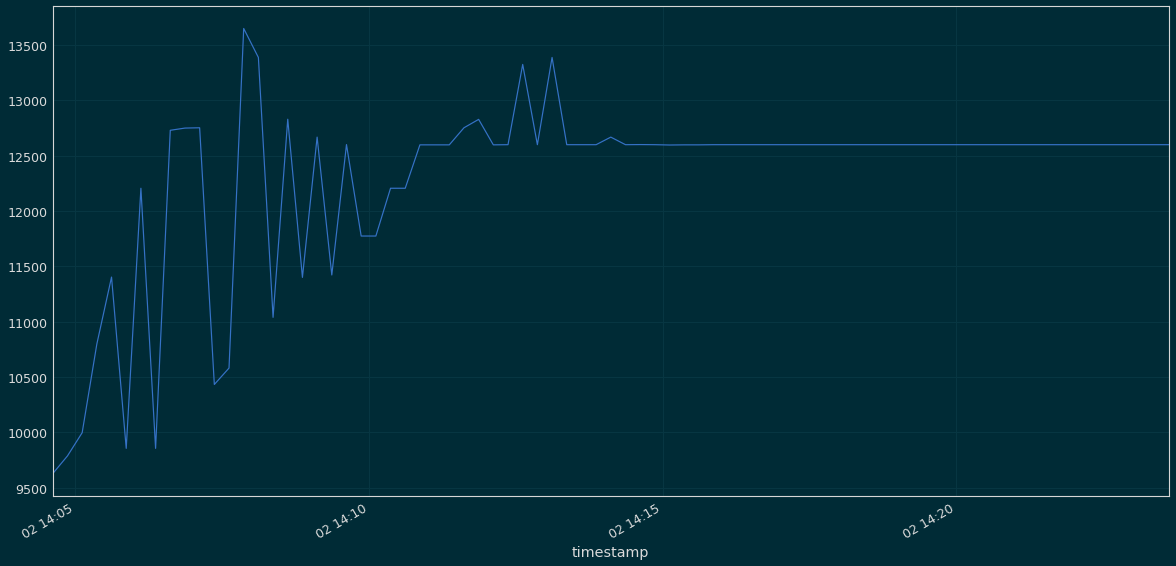

In [57]:
new_data[new_data.uid == '1476_278'].set_index('timestamp').sort_index().d_6274.plot(style='-')

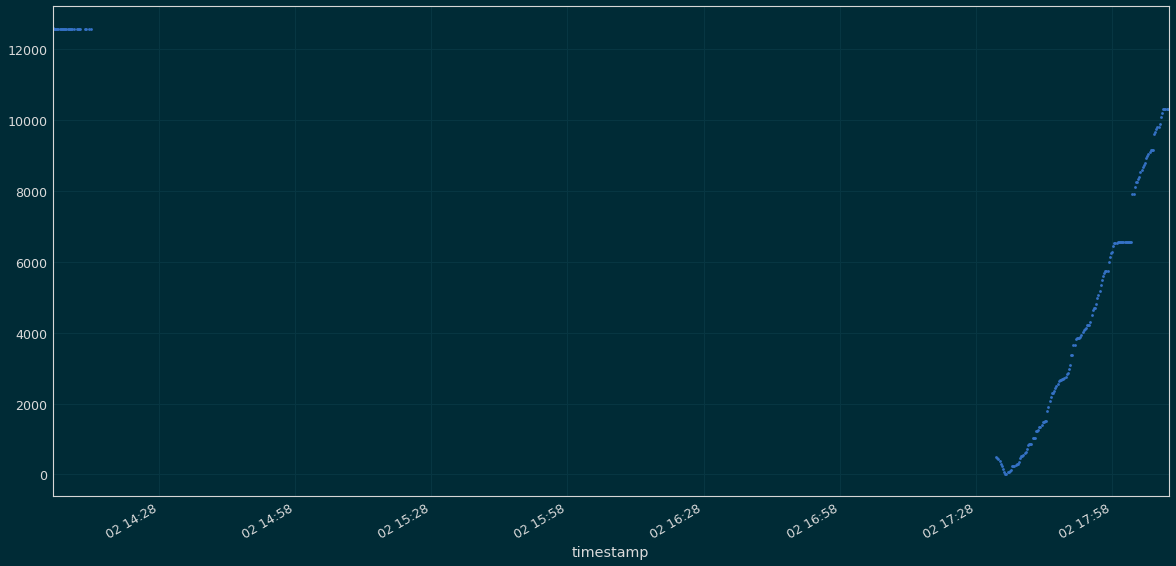

In [65]:
new_data[new_data.uid == '1476_275'].set_index('timestamp').sort_index().d_6274.plot(style='.')

In [74]:
paths[paths.linea == '1476']

calle  codigoParada                         esquina  \
2614            SARANDI          6274                          JUNCAL   
2615     AV 18 DE JULIO          3177                      CONVENCION   
2616     AV 18 DE JULIO          4189                  PLAZA CAGANCHA   
2617     AV 18 DE JULIO          3179                           EJIDO   
2618     AV 18 DE JULIO          4204                      TACUAREMBO   
2619     AV 18 DE JULIO          4202                          GABOTO   
2620    EDUARDO ACEVEDO          3849                        GUAYABOS   
2621  JOSE ENRIQUE RODO          4002               DR PABLO DE MARIA   
2622  JOSE ENRIQUE RODO          4087              DR JOAQUIN REQUENA   
2623  JOSE ENRIQUE RODO          4003              DR MARIO CASSINONI   
2624     AV GRAL RIVERA          2969             AV ING LUIS P PONCE   
2625     AV GRAL RIVERA          2970                   SIMON BOLIVAR   
2626     AV GRAL RIVERA          3890            AV DR FRANCISCO SOCA   
2627     AV GRAL RIVERA          3891           BRIG GRAL DIEGO LAMAS   
2628     AV GRAL RIVERA          2971                FRANCISCO LLAMBI   
2629     AV GRAL RIVERA          4881                     14 DE JULIO   
2630     AV GRAL RIVERA          2972             ALEJO ROSELL Y RIUS   
2631     AV GRAL RIVERA          2973       DOLORES PEREIRA DE ROSELL   
2632     AV GRAL RIVERA          3887                     JULIO CESAR   
2633     AV GRAL RIVERA          2974      AV LUIS ALBERTO DE HERRERA   
2634     AV GRAL RIVERA          2975                  TIBURCIO GOMEZ   
2635     AV GRAL RIVERA          2976                TOMAS DE TEZANOS   
2636     AV GRAL RIVERA          2977                 NICOLAS PIAGGIO   
2637     AV GRAL RIVERA          2978                   TOMAS BASAÑEZ   
2638     AV GRAL RIVERA          2979        BV JOSE BATLLE Y ORDOÑEZ   
2639     AV GRAL RIVERA          2980  AV MCAL FRANCISCO SOLANO LOPEZ   
2640         ARRASCAETA          3245                           VERDI   
2641              VERDI          3246                AMBROSIO VELAZCO   
2642              VERDI          3247                      9 DE JUNIO   
2643          AMSTERDAM          3248                          VELSEN   
2644             VELSEN          3249                SANTIAGO DE ANCA   
2645            ALMERIA          3250                            YACO   
2646            ALMERIA          3251               HIPOLITO YRIGOYEN   
2647            ALMERIA          3252                       ACONCAGUA   
2648          ACONCAGUA          3253                 RIO DE LA PLATA   
2649          ACONCAGUA          3254                        MICHIGAN   
2650          ACONCAGUA          3255              ENRIQUE ESTRAZULAS   
2651          ACONCAGUA          3256                        MISSOURI   
2652          ACONCAGUA          3257           DR ALEJANDRO GALLINAL   
2653           CARAMURU          3258           ING JOSE ACQUISTAPACE   
2654           CARAMURU          3259                 GRITO DE GLORIA   
2655           CARAMURU          3260                  MARIA ESPINOLA   
2656           CARAMURU          3261                          PRIAMO   
2657           CARAMURU          3262          AV GRAL JOSE MARIA PAZ   
2658           CARAMURU          3269                      BELASTIQUI   
2659           CARAMURU          3270                   AV SAN MARINO   
2660         AV BOLIVIA          2964                  AV GRAL RIVERA   
2661         AV BOLIVIA          2960                        FRIBURGO   
2662         AV BOLIVIA          2959          AV GRAL JOSE MARIA PAZ   
2663         AV BOLIVIA          2967     AV DR JUAN BAUTISTA ALBERDI   
2664         AV BOLIVIA          2968                       AV ITALIA   
2665          AV ITALIA          4835                      AV BOLIVIA   

            lat linea       long  ordinal             x            y  
2614 -34.906435  1476 -56.201029        1  -1346.241990  -350.833525  
2615 -

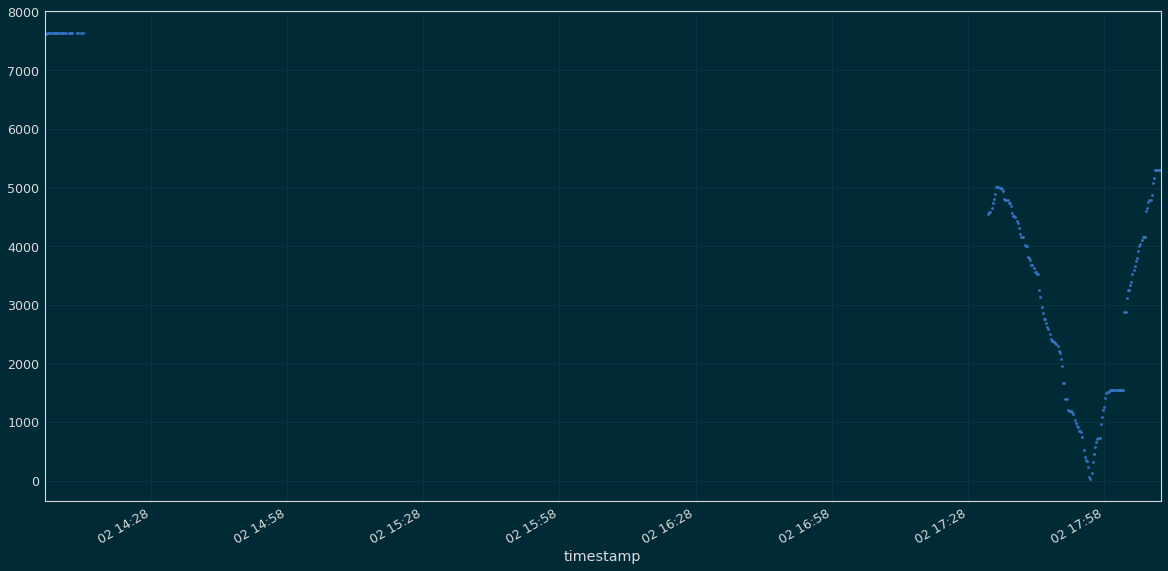

In [75]:
new_data[new_data.uid == '1476_275'].set_index('timestamp').sort_index().d_3891.plot(style='.')

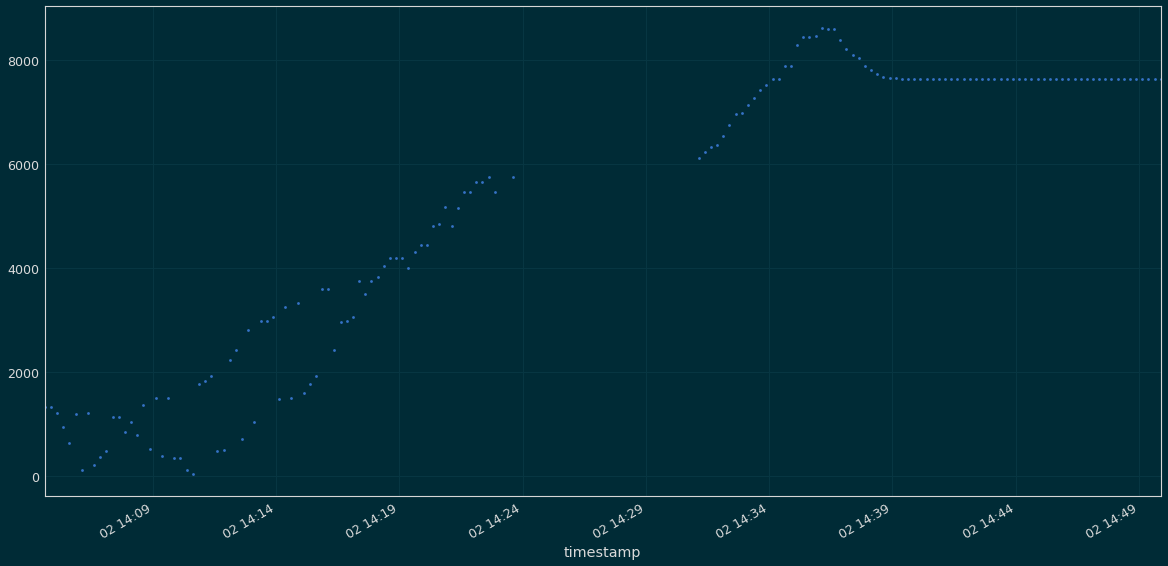

In [80]:
new_data[new_data.uid == '1476_263'].set_index('timestamp').sort_index().d_3891.plot(style='.')

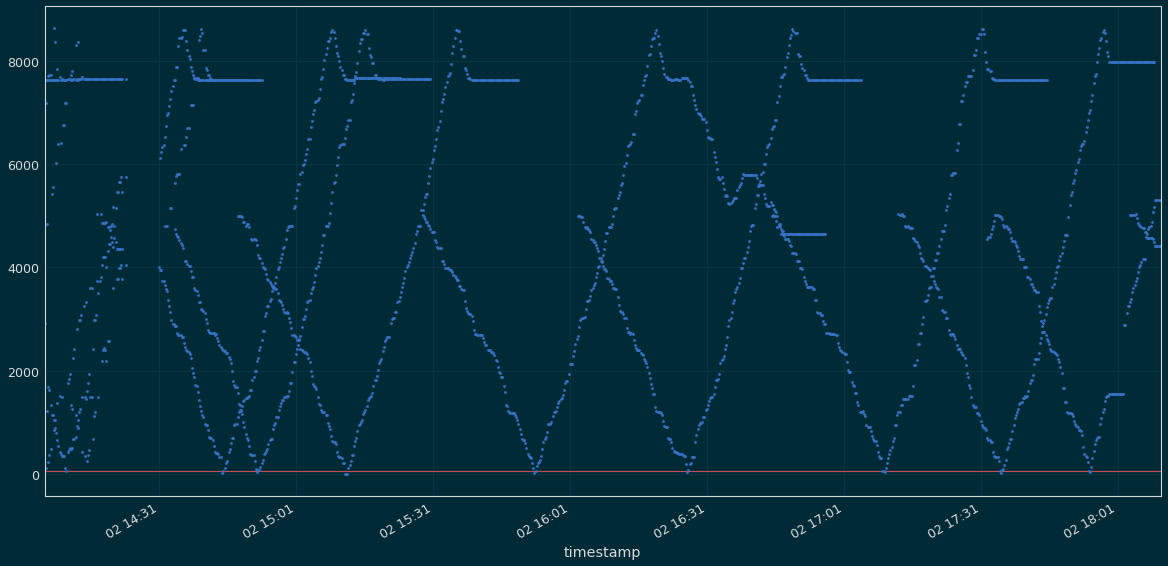

In [88]:
line_dists = new_data[new_data.linea == '1476'].set_index('timestamp').sort_index().d_3891.iloc[300:]
line_dists.plot(style='.')
plt.hlines(50, line_dists.index.min(), line_dists.index.max(), 'r')

In [79]:
new_data.timestamp.apply(lambda x: x.date()).unique()

array([datetime.date(2018, 10, 2), datetime.date(2018, 10, 1)], dtype=object)

### Let's save that

In [66]:
new_data.to_pickle(os.path.join(DATA_INTERIM, 'easy_dists.pkl'))

## 4. Times of Arrival <a id='ta'>
[Top](#top)

In [33]:
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
from jupyterthemes import jtplot
import datetime as dt
import seaborn as sns
import json

import matplotlib.pyplot as plt
%matplotlib inline
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

ROOT_DIR = '/home/miguel/github_repos/python-ds'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')

DATA = os.path.join(DATA_INTERIM, 'data.pkl')
PATHS = os.path.join(DATA_PROCESSED, 'paths.pkl')
SIM_DATA = os.path.join(DATA_INTERIM, 'sim_data.pkl')

SRC_DIR = os.path.join(ROOT_DIR, 'src')

import sys
sys.path.append(SRC_DIR)

import data.create_from_sim as cfs
import data.create_from_txt as cft
import data.paths as p
import data.target_creation as tc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = pd.read_pickle(os.path.join(DATA_INTERIM, 'easy_dists.pkl'))
paths = pd.read_pickle(PATHS)

In [4]:
def get_one_travel(data, uid, stop_id):
    return pd.DataFrame(data[data.uid == uid].set_index('timestamp').sort_index()[stop_id])

In [5]:
uid = '1476_275'
stop_id = 'd_3891'
stop_id = 'd_3177'
dists = get_one_travel(data, uid, stop_id)
dists.head()

d_3177
timestamp                        
2018-10-02 14:04:37  12118.380673
2018-10-02 14:04:52  12117.276126
2018-10-02 14:05:07  12115.507624
2018-10-02 14:05:22  12115.507624
2018-10-02 14:05:37  12115.507624

In [6]:
(dists < 50).sum()

d_3177    6
dtype: int64

In [7]:
dists['in_stop'] = dists[stop_id] < 50.0
dists.head()

d_3177  in_stop
timestamp                                 
2018-10-02 14:04:37  12118.380673    False
2018-10-02 14:04:52  12117.276126    False
2018-10-02 14:05:07  12115.507624    False
2018-10-02 14:05:22  12115.507624    False
2018-10-02 14:05:37  12115.507624    False

In [8]:
def time_list_mean(time_list):
    return pd.Timestamp.fromtimestamp(
        np.mean(list(map(lambda x: x.timestamp(), time_list))))

In [9]:
def get_one_ta(proximity):
    """
    Get the next time of arrival given a dataframe with booleans that represent that
    the bus is (or isn't) in the bus stop ('in_stop' column).
    """
    prox_t = proximity.reset_index()
    cluster_timestamps = list()
    ta = None
    last_in_stop = None
    for idx in range(prox_t.shape[0]):
        if prox_t.in_stop.iloc[idx]:
            for j in range(idx, prox_t.shape[0]):
                cluster_timestamps.append(prox_t.timestamp.iloc[j])
                if not prox_t.in_stop.iloc[j]:
                    break
            if prox_t.in_stop.iloc[j]:
                last_in_stop = j
            else:
                last_in_stop = j - 1
            break
    if len(cluster_timestamps) > 0:
        ta = time_list_mean(cluster_timestamps)
    return ta, last_in_stop

In [10]:
def fill_arrival_times(proximity, col_name, min_dist):
    """
    Receives a Series of booleans indexed in timestamps, and 
    calculates the mean time of the "True" values clusters.
    It fills those values backwards.
    """
    new_col_name = col_name + '_ta'
    temp_prox = proximity.copy()
    temp_prox['in_stop'] = temp_prox[col_name] < min_dist
    temp_prox = temp_prox.sort_index()
    temp_prox[new_col_name] = np.full((temp_prox.shape[0],), np.nan)
    
    pre_last_in_stop = 0
    while pre_last_in_stop <= temp_prox.shape[0]:
        ta, last_in_stop = get_one_ta(temp_prox.iloc[pre_last_in_stop:, :])
        if ta is None:
            break
        start = temp_prox.index[pre_last_in_stop]
        end = temp_prox.index[pre_last_in_stop + last_in_stop]
        temp_prox.loc[start:end,new_col_name] = ta 
        pre_last_in_stop += last_in_stop + 1
    return temp_prox[new_col_name]

In [11]:
def get_relevant_d_stops(paths, uid=None, line=None):
    """ 
    Pass a uid or a line, and it returns all the stop distances 
    column names. uid and line cannot be both None.
    """
    if line is None:
        line = uid.split('_')[0]
    line_stops = relevant_stops(paths, line).codigoParada
    return line_stops.apply(lambda x: 'd_{}'.format(x))

In [12]:
def fill_one_uid(data, paths, uid, min_dist=50.0):
    """ Fills the times of arrival for one uid, and all the relevant bus stops. """
    temp_data = data.copy().set_index('timestamp')
    for col in get_relevant_d_stops(paths, uid=uid):
        new_col = col + '_ta'
        if not (new_col in temp_data.columns):
            temp_data[new_col] = np.full((temp_data.shape[0],), pd.NaT)
        dists = pd.DataFrame(temp_data[col])
        temp_data.update(fill_arrival_times(dists, col, min_dist))
    ta_cols = temp_data.columns.str.contains('_ta')
    temp_data.loc[:, ta_cols] = temp_data.loc[:, ta_cols].apply(
        lambda x: pd.to_datetime(x))
    return temp_data

In [13]:
time_list_mean(dists.index.tolist())

Timestamp('2018-10-02 17:17:58.138889')

29
2018-10-02 17:32:57


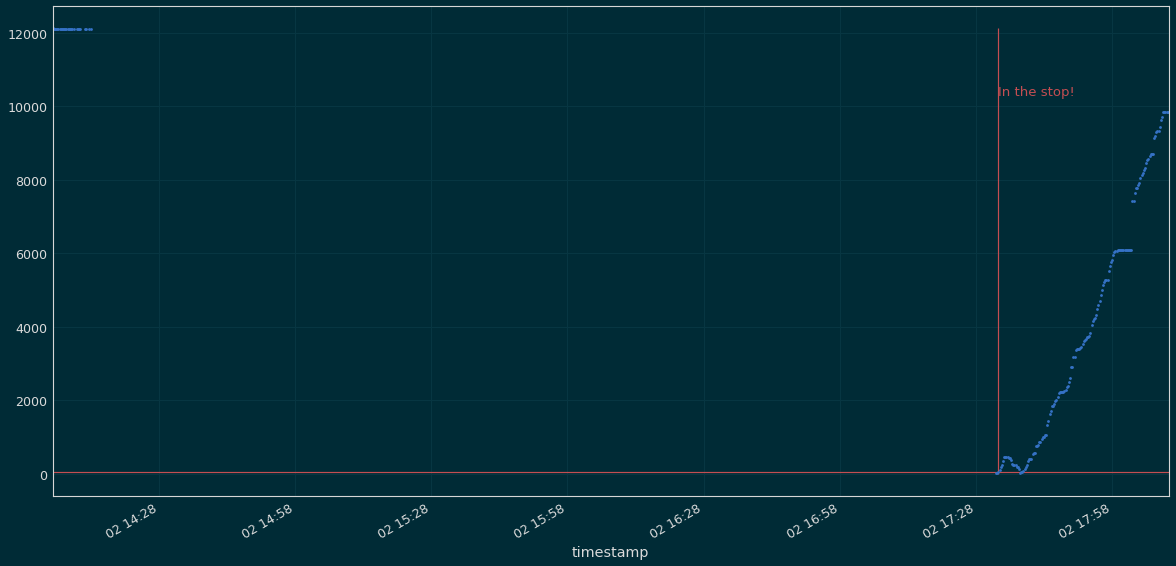

In [14]:
ta, last_in_stop = get_one_ta(dists)
dists[stop_id].plot(style='.')
plt.vlines(ta, 0, dists[stop_id].max(), 'r')
plt.text(ta, dists[stop_id].max()*0.85, 'In the stop!', color='r')
plt.hlines(50, dists.index.min(), dists.index.max(), 'r')
print(last_in_stop)
print(dists.index[last_in_stop])

In [15]:
result = fill_arrival_times(dists, dists.columns[0], 50.0)
result.head()

timestamp
2018-10-02 14:04:37    2018-10-02 17:32:49.500000
2018-10-02 14:04:52    2018-10-02 17:32:49.500000
2018-10-02 14:05:07    2018-10-02 17:32:49.500000
2018-10-02 14:05:22    2018-10-02 17:32:49.500000
2018-10-02 14:05:37    2018-10-02 17:32:49.500000
Name: d_3177_ta, dtype: object

In [16]:
result.tail()

timestamp
2018-10-02 18:09:28    NaN
2018-10-02 18:09:43    NaN
2018-10-02 18:09:58    NaN
2018-10-02 18:10:13    NaN
2018-10-02 18:10:28    NaN
Name: d_3177_ta, dtype: object

In [17]:
uid = '1476_275'
stop_id = 'd_3177'
dists2 = get_one_travel(data, uid, stop_id)
res2 = fill_arrival_times(dists2, dists2.columns[0], 50.0)
res2.head()

timestamp
2018-10-02 14:04:37    2018-10-02 17:32:49.500000
2018-10-02 14:04:52    2018-10-02 17:32:49.500000
2018-10-02 14:05:07    2018-10-02 17:32:49.500000
2018-10-02 14:05:22    2018-10-02 17:32:49.500000
2018-10-02 14:05:37    2018-10-02 17:32:49.500000
Name: d_3177_ta, dtype: object

In [18]:
res2.unique()

array([Timestamp('2018-10-02 17:32:49.500000'),
       Timestamp('2018-10-02 17:38:04.500000'), nan], dtype=object)

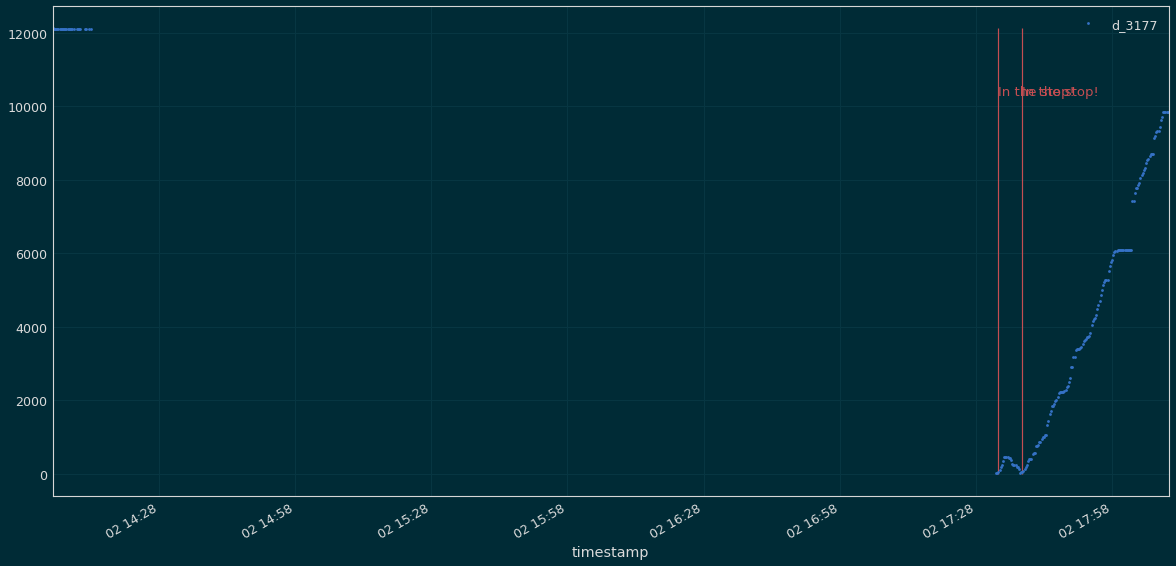

In [19]:
dists2.plot(style='.')
for time in res2.dropna().unique():
    plt.vlines(time, 0, dists2[stop_id].max(), 'r')
    plt.text(time, dists2[stop_id].max()*0.85, 'In the stop!', color='r')

In [20]:
uid = '1476_275'
res = tc.fill_one_uid(data[data.uid == uid], paths, uid)
res.head()

codigoBus        lat linea       long       uid  \
timestamp                                                              
2018-10-02 14:04:37        275 -34.883250  1476 -56.083275  1476_275   
2018-10-02 14:04:52        275 -34.883167  1476 -56.083305  1476_275   
2018-10-02 14:05:52        275 -34.882526  1476 -56.083473  1476_275   
2018-10-02 14:06:22        275 -34.882526  1476 -56.083473  1476_275   
2018-10-02 14:05:07        275 -34.882526  1476 -56.083473  1476_275   

                                x            y  d_553  d_554  d_574  \
timestamp                                                             
2018-10-02 14:04:37  10972.457722  2227.234381    NaN    NaN    NaN   
2018-10-02 14:04:52  10969.319297  2236.463560    NaN    NaN    NaN   
2018-10-02 14:05:52  10951.744116  2307.739508    NaN    NaN    NaN   
2018-10-02 14:06:22  10951.744116  2307.739508    NaN    NaN    NaN   
2018-10-02 14:05:07  10951.744116  2307.739508    NaN    NaN    NaN   

                            ...                       d_3891_ta  \
timestamp                   ...                                   
2018-10-02 14:04:37         ...         2018-10-02 17:55:05.500   
2018-10-02 14:04:52         ...         2018-10-02 17:55:05.500   
2018-10-02 14:05:52         ...         2018-10-02 17:55:05.500   
2018-10-02 14:06:22         ...         2018-10-02 17:55:05.500   
2018-10-02 14:05:07         ...         2018-10-02 17:55:05.500   

                                  d_4002_ta  d_4003_ta  d_4087_ta  \
timestamp                                                           
2018-10-02 14:04:37 2018-10-02 17:48:50.500        NaT        NaT   
2018-10-02 14:04:52 2018-10-02 17:48:50.500        NaT        NaT   
2018-10-02 14:05:52 2018-10-02 17:48:50.500        NaT        NaT   
2018-10-02 14:06:22 2018-10-02 17:48:50.500        NaT        NaT   
2018-10-02 14:05:07 2018-10-02 17:48:50.500        NaT        NaT   

                                  d_4189_ta               d_4202_ta  \
timestamp                                                             
2018-10-02 14:04:37 2018-10-02 17:40:49.500 2018-10-02 17:45:19.500   
2018-10-02 14:04:52 2018-10-02 17:40:49.500 2018-10-02 17:45:19.500   
2018-10-02 14:05:52 2018-10-02 17:40:49.500 2018-10-02 17:45:19.500   
2018-10-02 14:06:22 2018-10-02 17:40:49.500 2018-10-02 17:45:19.500   
2018-10-02 14:05:07 2018-10-02 17:40:49.500 2018-10-02 17:45:19.500   

                                  d_4204_ta                  d_4835_ta  \
timestamp                                                                
2018-10-02 14:04:37 2018-10-02 17:44:04.500 2018-10-02 14:16:18.153846   
2018-10-02 14:04:52 2018-10-02 17:44:04.500 2018-10-02 14:16:18.153846   
2018-10-02 14:05:52 2018-10-02 17:44:04.500 2018-10-02 14:16:18.153846   
2018-10-02 14:06:22 2018-10-02 17:44:04.500 2018-10-02 14:16:18.153846   
2018-10-02 14:05:07 2018-10-02 17:44:04.500 2018-10-02 14:16:18.153846   

                                  d_4881_ta           d_6274_ta  
timestamp                                                        
2018-10-02 14:04:37 2018-10-02 17:55:50.500 2018-10-02 17:34:42  
2018-10-02 14:04:52 2018-10-02 17:55:50.500 2018-10-02 17:34:42  
2018-10-02 14:05:52 2018-10-02 17:55:50.500 2018-10-02 17:34:42  
2018-10-02 14:06:22 2018-10-02 17:55:50.500 2018-10-02 17:34:42  
2018-10-02 14:05:07 2018-10-02 17:55:50.500 2018-10-02 17:34:42  

[5 rows x 1103 columns]

In [21]:
res.uid.unique()

array(['1476_275'], dtype=object)

### Let's compute the targets in parallel

In [22]:
def fill_one_uid_para(uid_data):
    uid = uid_data.uid.iloc[0]
    return tc.fill_one_uid(uid_data, paths, uid)

In [23]:
import utils
data = pd.read_pickle(os.path.join(DATA_INTERIM, 'easy_dists.pkl'))
print('There are {} uids'.format(data.uid.unique().shape[0]))
target_data = utils.apply_parallel(data.groupby('uid'), tc.fill_one_uid_para)

There are 546 uids
('1476_262', '1476_263', '1476_275', '1476_276', '1476_278', '1476_285', '1476_286', '1476_525', '1476_570', '1476_574', '1476_589', '1476_962', '1476_965', '1476_969', '1483_254', '1483_262', '1483_275', '1483_285', '1483_525', '1483_536', '1483_570', '1483_571', '1483_589', '1483_678', '1483_770', '1483_962', '1483_965', '1483_969', '1483_975', '217_10', '217_105', '217_106', '217_11', '217_13', '217_15', '217_16', '217_20', '217_29', '217_34', '217_35', '217_40', '217_41', '217_45', '217_5', '217_52', '217_6', '217_68', '217_69', '217_76', '217_77', '217_82', '217_83', '217_88', '217_90', '217_91', '217_92', '217_93', '217_99', '218_10', '218_100', '218_105', '218_13', '218_15', '218_20', '218_25', '218_29', '218_30', '218_34', '218_35', '218_40', '218_41', '218_45', '218_46', '218_5', '218_52', '218_53', '218_6', '218_68', '218_69', '218_76', '218_82', '218_83', '218_88', '218_90', '218_91', '218_92', '218_93', '218_99', '227_13', '227_33', '227_34', '227_50', '2

In [24]:
target_data = target_data.reset_index().drop('group_index', axis=1)

In [25]:
target_data.to_pickle(os.path.join(DATA_INTERIM, 'dists_and_tas.pkl'))

In [26]:
target_data.shape

(140060, 2096)

In [27]:
target_data.head()

timestamp  codigoBus  d_1068 d_1068_ta  d_1069 d_1069_ta  d_1109  \
0 2018-10-02 17:12:57        262     NaN       NaT     NaN       NaT     NaN   
1 2018-10-02 17:13:12        262     NaN       NaT     NaN       NaT     NaN   
2 2018-10-02 17:13:27        262     NaN       NaT     NaN       NaT     NaN   
3 2018-10-02 17:13:42        262     NaN       NaT     NaN       NaT     NaN   
4 2018-10-02 17:13:57        262     NaN       NaT     NaN       NaT     NaN   

  d_1109_ta  d_1121 d_1121_ta     ...      d_6299 d_6299_ta  d_6301 d_6301_ta  \
0       NaT     NaN       NaT     ...         NaN       NaT     NaN       NaT   
1       NaT     NaN       NaT     ...         NaN       NaT     NaN       NaT   
2       NaT     NaN       NaT     ...         NaN       NaT     NaN       NaT   
3       NaT     NaN       NaT     ...         NaN       NaT     NaN       NaT   
4       NaT     NaN       NaT     ...         NaN       NaT     NaN       NaT   

         lat linea       long       uid            x           y  
0 -34.906445  1476 -56.200943  1476_262 -1337.282996 -351.931943  
1 -34.906500  1476 -56.200806  1476_262 -1322.950854 -358.047664  
2 -34.906580  1476 -56.200890  1476_262 -1331.738445 -366.943258  
3 -34.907030  1476 -56.200890  1476_262 -1331.738445 -416.980975  
4 -34.906803  1476 -56.200695  1476_262 -1311.338681 -391.739727  

[5 rows x 2096 columns]

In [34]:
target_data.loc[:, target_data.columns.str.contains('_ta')].isnull().mean().mean()

0.9760168534776839